## Spectral Analysis of Real World Surf Session:

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#from mpl_toolkits.basemap import Basemap

import pandas as pd
import numpy as np

from scipy import stats
from scipy import constants
from scipy import signal #added
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
from scipy.integrate import simps
from scipy.integrate import cumtrapz

import os
import datetime
import pytz
import re

import peakutils
import statsmodels.api as sm

import requests


from plotly import tools #added all the plotly's
import plotly.offline
import plotly.graph_objs as go

import math #added
import re   #added

# For the definition of the abstract base class IMU_Base
import abc

import sys

# %matplotlib notebook
%matplotlib inline


In [2]:
## Read from CSV
#Full csv:
#scripps_final_combined = pd.read_csv('Scripps_Final_Combined.csv')
#print(scripps_final_combined.head())

#Gets following columns: UTC, Time, IMU A1, IMU A2, IMU A3, IMU G1, IMU G2, IMU G3, IMU M1, IMU M2, Date
motion_df = pd.read_csv('Scripps_Final_Combined.csv', usecols = [i for i in range(2, 13)])
#motion_df = motion_df.drop(['Time'], axis=1)
print(motion_df.head())
print(len(motion_df))

                              UTC   Time    IMU A1     IMU A2    IMU A3  \
0  2017-09-09T18:02:11.2810+00:00  18:02  0.000000  11.070788  0.134075   
1  2017-09-09T18:02:11.4800+00:00  18:02 -0.325611  11.185710 -0.459687   
2  2017-09-09T18:02:11.7310+00:00  18:02  0.000000  10.419566  1.800440   
3  2017-09-09T18:02:11.9810+00:00  18:02  0.823605  10.860099 -0.114922   
4  2017-09-09T18:02:12.1800+00:00  18:02  0.670376  11.492168 -0.651223   

      IMU G1     IMU G2     IMU G3  IMU M1  IMU M2  IMU M3  
0  46.829268  15.853659  15.487805   -37.0  -199.0   517.0  
1   8.902439  -2.439024  12.073171   -33.0  -179.0   533.0  
2 -16.341463   1.463415  14.268293   -46.0  -188.0   528.0  
3  -5.731707  17.439024  21.707317   -64.0  -186.0   522.0  
4 -28.658537   1.219512  21.341463   -91.0  -175.0   493.0  
1538168


## Make a copy of the original motion_df dataframe

In [3]:
#print(motion_df)

saved_copy_motion_df = motion_df.copy(deep=True) #make a copy of the dataframe with raw data

print(saved_copy_motion_df)

                                    UTC   Time    IMU A1     IMU A2    IMU A3  \
0        2017-09-09T18:02:11.2810+00:00  18:02  0.000000  11.070788  0.134075   
1        2017-09-09T18:02:11.4800+00:00  18:02 -0.325611  11.185710 -0.459687   
2        2017-09-09T18:02:11.7310+00:00  18:02  0.000000  10.419566  1.800440   
3        2017-09-09T18:02:11.9810+00:00  18:02  0.823605  10.860099 -0.114922   
4        2017-09-09T18:02:12.1800+00:00  18:02  0.670376  11.492168 -0.651223   
...                                 ...    ...       ...        ...       ...   
1538163  2019-01-04T20:16:02.7080+00:00  20:16  8.216900   5.152322  0.536301   
1538164  2019-01-04T20:16:02.9080+00:00  20:16  8.178593   5.133168  0.517148   
1538165  2019-01-04T20:16:03.1010+00:00  20:16  8.159439   5.171476  0.517148   
1538166  2019-01-04T20:16:03.3020+00:00  20:16  8.159439   5.152322  0.536301   
1538167  2019-01-04T20:16:03.5040+00:00  20:16  8.140286   5.171476  0.517148   

            IMU G1     IMU 

## Calcualting time_elapseds, time_offsets and creating IMU1, IMU2, and IMU3 raw data lists

In [4]:
#Reading data from Scripps_Final_Combined.csv
#The name of the motion dataframe is: motion_df

#Get times from the "Time" column to create time_o_list and time_e_list.
#Get imus from the "IMU A[*]" column to create the imu acc arrays. 

#Analyze following time period:
#September 9, 2017 -- 18:10 until 18:40

time_e_array = []

time_array = motion_df[['Time']].to_numpy()

#Convert time strings into seconds
start_index = np.where(time_array=='15:20')[0][0]
end_index = np.where(time_array=='15:50')[0][0]
length = end_index-start_index

mins_per_measure = 30/length
sec_per_measure = 60*mins_per_measure

print(sec_per_measure)

#start_time = 18*3600 + 10*60

for i in range(0, length):
    time_e_array.append(sec_per_measure*i)
    
imu_array1 = motion_df.loc[start_index:end_index-1,'IMU A1'].to_numpy()
imu_array2 = motion_df.loc[start_index:end_index-1,'IMU A2'].to_numpy()
imu_array3 = motion_df.loc[start_index:end_index-1,'IMU A3'].to_numpy()





0.25020850708924103


## Convert raw units to actual units (acc to [m/s^2]) and (time to [s])

7194
7194
Graph of our entire experiment:


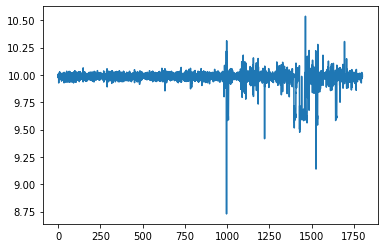

In [5]:
## Convert raw units to actual units (acc to [m/s^2]) and (time to [s])


#Raw acceleration constant 512 = 1g (accelerometer's measured force due to gravity)
g_const = 512

#Approximate measurement for gravity:
gravity = 9.80665


# Correct the IMU Acceleration columns into units of meters
# Dividing by 512 is equivalent to muliplying by 4 to correct the bit shifting by 2 places and dividing by 2048 to convert bits to G's
# Multiplying by the 9.81 afterwards is simply to convert G's into m/s^2

def convert_acc_units(acc_array):
    ret_array = []
    for a in acc_array:
        #Acceleration is now in m/s^2, need to subtract gravity from vertical axis. (??)
        new_a = a / g_const * gravity + gravity
        ret_array.append(new_a)
    return ret_array

imu1_array = convert_acc_units(imu_array1) #new units in m/s^2
imu2_array = convert_acc_units(imu_array2) #new units in m/s^2
imu3_array = convert_acc_units(imu_array3) #new units in m/s^2

#To check:
#for x,y in zip(imu2_array, imu_array2):
#    print(x,y)
    
    
#def convert_time_units(time_array):
  #  ret_array = []
  #  for t in time_array:
   #     new_t = t * (10**(-3)) #converting units in milliseconds to seconds
    #    ret_array.append(new_t)
   # return ret_array

#time_o_array = convert_time_units(time_o_list) #new units in seconds
#time_e_array = convert_time_units(time_e_list) #new units in seconds

##To check:
#for t in time_e_array:
#    print(t)

print(len(time_e_array))
#print(len(time_e_list))
print(len(imu2_array)) 

print("Graph of our entire experiment:")

plt.plot(time_e_array, imu2_array)
#plt.ylim(-1,1)
plt.show()

#print("Why are the y-axis values so small?")

## PSD Step 1: Seperate each of the subexperiments into its own acc lists

In [6]:
#for x in time_e_array:
#    print(x)

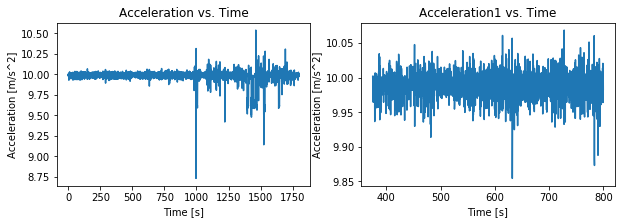

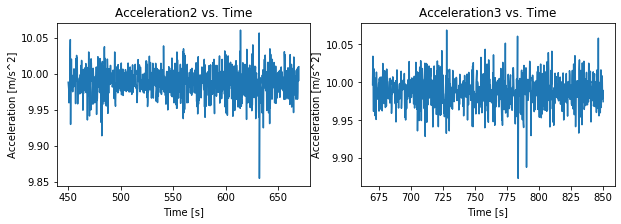

In [7]:
#Seperate each of the subexperiments into its own acc lists.
#i.e. subexperiment1 corresponds to acc1, (subexperiment2 => acc2), etc.

time_e_list1 = []
time_e_list2 = []
time_e_list3 = []

acc_list = []
acc_list1 = []
acc_list2 = []
acc_list3 = []

time_array = []
acc_array = []


#For our controlled experiments, we know that imu2 is the vertical axis
acc_list = imu2_array
time_array = time_e_array


#i = 0
#while (i < len(imu2_array)):
#    imu2_array[i] = imu2_array[i] - gravity
#    i = i + 1
#print(imu2_array)

i = 0
while (i < (len(acc_list)) - 1):
    if (time_e_array[i] > 375 and time_e_array[i] <= 800):
        acc_list1.append(acc_list[i])
        time_e_list1.append(time_e_array[i])
    if (time_e_array[i] > 450 and time_e_array[i] <= 670):
        acc_list2.append(acc_list[i])
        time_e_list2.append(time_e_array[i])
    if (time_e_array[i] > 670 and time_e_array[i] <= 850):
        acc_list3.append(acc_list[i])
        time_e_list3.append(time_e_array[i])
    i = i + 1
    
#Plot the subexperiments to verify correctness:
acc_array = np.array(acc_list)   #acc_list gets vertical acceleration from y-axis imu2


time_array1 = np.array(time_e_list1)
acc_array1 = np.array(acc_list1)
time_array2 = np.array(time_e_list2)
acc_array2 = np.array(acc_list2)
time_array3 = np.array(time_e_list3)
acc_array3 = np.array(acc_list3)
  
    
##Plotting:
f1 = plt.figure(figsize=(10,3))
ax1 = f1.add_subplot(121)
ax2 = f1.add_subplot(122)

f2 = plt.figure(figsize=(10,3))
ax3 = f2.add_subplot(121)
ax4 = f2.add_subplot(122)

ax1.plot(time_array, acc_array)
ax1.set_title("Acceleration vs. Time")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel('Acceleration [m/s^2]')


ax2.plot(time_array1, acc_array1)
ax2.set_title("Acceleration1 vs. Time")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Acceleration [m/s^2]")
#ax2.set_ylim([-6,6])

#ax2.axhline(y=-0.8, color="green")
#ax2.axhline(y=0.8, color="red")

ax3.plot(time_array2, acc_array2)
ax3.set_title("Acceleration2 vs. Time")
ax3.set_xlabel("Time [s]")
ax3.set_ylabel("Acceleration [m/s^2]")
#ax3.set_ylim([-6,6])

ax4.plot(time_array3, acc_array3)
ax4.set_title("Acceleration3 vs. Time")
ax4.set_xlabel("Time [s]")
ax4.set_ylabel("Acceleration [m/s^2]")
#ax4.set_ylim([-6,6])

plt.show()
    

## PSD Step 2: Detrend the data 

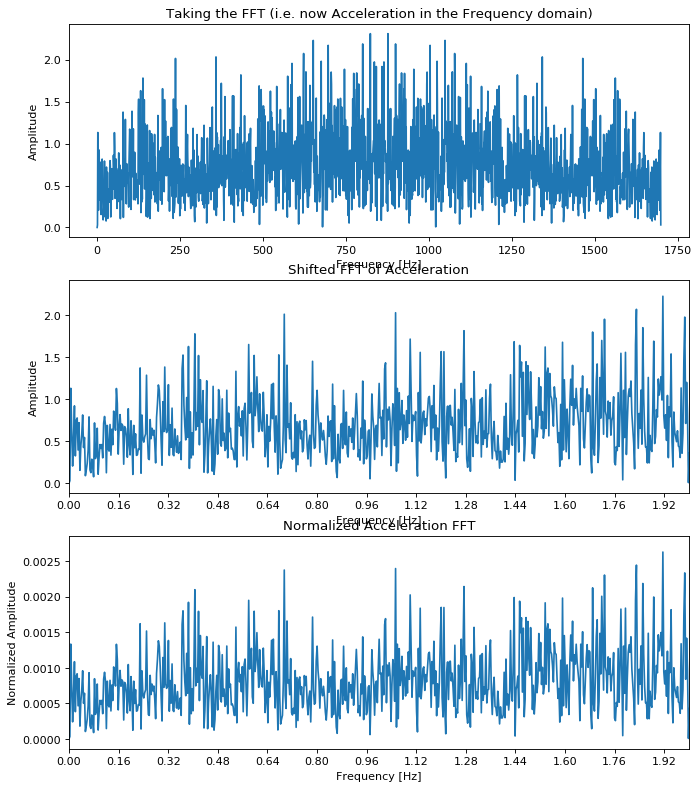

This is the output after shifting the FFT of the second derivative 
 i.e. the FFT of acceleration.
This looks promising since the amplitude of the last graph matches the amplitude of the acceleration graph from the second derivative (above).


In [8]:
##PSD Step 2: Detrend the data 
dacc_array1 = signal.detrend(acc_array1)
dacc_array2 = signal.detrend(acc_array2)
dacc_array3 = signal.detrend(acc_array3)

f_s = 5.0 #sampling frequency

#Taking the FFT of acceleration:
fft_acc1 = np.fft.fft(dacc_array1)
len_fft_acc1 = len(fft_acc1)
freq_acc1 = np.fft.fftfreq(len_fft_acc1, 1/f_s)

#Shifting the FFT of acceleration:
fft_acc1_shifted = np.fft.fftshift(fft_acc1)
freq_acc1_shifted = np.fft.fftshift(freq_acc1)

#Normalize:
fft_acc1_normal = np.abs(fft_acc1_shifted/len_fft_acc1)*2

#Plot:
fig = plt.figure(num=None, figsize=(10, 12), dpi=80, facecolor='w', edgecolor='k')


# Returns the Axes instance
ax1 = fig.add_subplot(311) 
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)


ax1.plot(np.abs(fft_acc1))
ax1.set_title('Taking the FFT (i.e. now Acceleration in the Frequency domain)')
ax1.set_xlabel('Frequency [Hz]')
ax1.set_ylabel('Amplitude')

ax2.plot(freq_acc1_shifted, np.abs(fft_acc1_shifted))
ax2.set_title('Shifted FFT of Acceleration')
ax2.set_xlabel('Frequency [Hz]')
ax2.set_ylabel('Amplitude')
ax2.set_xlim(0,2)
ax2.set_xticks(np.arange(0,2, step=.16))

ax3.plot(freq_acc1_shifted, fft_acc1_normal)
ax3.set_title('Normalized Acceleration FFT')
ax3.set_xlabel('Frequency [Hz]')
ax3.set_ylabel('Normalized Amplitude')
ax3.set_xlim(0,2)
ax3.set_xticks(np.arange(0,2, step=.16))

plt.show()

print("This is the output after shifting the FFT of the second derivative \n i.e. the FFT of acceleration.")
print("This looks promising since the amplitude of the last graph matches the amplitude of the acceleration graph from the second derivative (above).")





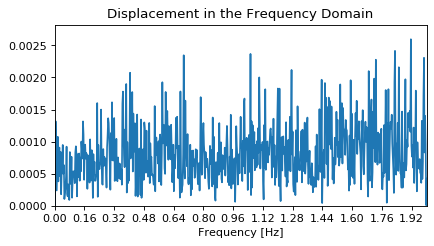

In [9]:
#Now, multiply the accelerations by 1/w^2 to get the displacement in the frequency domain:
f = 0.16

w = 2*np.pi*f
omega = 1/w**2

disp1_normal = []

for a in fft_acc1_normal:
    new_a = a*omega
    disp1_normal.append(new_a)

#So now new_list should have the new values, 
#representing displacement in the frequency domain.
fig = plt.figure(num=None, figsize=(6,3), dpi=80, facecolor='w', edgecolor='k')

# Returns the Axes instance
ax = fig.add_subplot(111) 


ax.plot(freq_acc1_shifted, disp1_normal)
ax.set_title("Displacement in the Frequency Domain")
ax.set_xlabel('Frequency [Hz]')
plt.xlim(0,2)
plt.ylim(0,)
plt.xticks(np.arange(0,2, step=.16))

plt.show()

In [10]:
def calc_displacement_fft(acc_array, f_s): 
    
    ##PSD Step 2: Detrend the data 
    dacc_array = signal.detrend(acc_array)

    #Taking the FFT of acceleration:
    fft_acc = np.fft.fft(dacc_array)
    len_fft_acc = len(fft_acc)
    freq_acc = np.fft.fftfreq(len_fft_acc, 1/f_s)

    #Shifting the FFT of acceleration:
    fft_acc_shifted = np.fft.fftshift(fft_acc)
    freq_acc_shifted = np.fft.fftshift(freq_acc)

    #Normalize:
    fft_acc_normal = np.abs(fft_acc_shifted/len_fft_acc)*2


    #Now, multiply the accelerations by 1/w^2 to get the displacement in the frequency domain:

    f = 0.16  #Need to not hardcode this number - find it using max.

    w = 2*np.pi*f
    omega = 1/w**2

    disp_normal = []

    for a in fft_acc_normal:
        new_a = a*omega
        disp_normal.append(new_a)

    #So now disp_normal should have the new values, 
    #representing displacement in the frequency domain.

    
    #Calculating wave statistics
    peak_freq = np.abs(freq_acc_shifted[np.argmax(disp_normal)])
    wave_height = disp_normal[np.argmax(disp_normal)]*2 #multiply by 2 because total height is from peak to trough
    
    
    
    
    #Plot:
    fig = plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')


    # Returns the Axes instance
    ax1 = fig.add_subplot(221) 
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224) 


    ax1.plot(np.abs(fft_acc))
    ax1.set_title('Taking the FFT (i.e. now Acceleration in the Frequency domain)')
    ax1.set_xlabel('Frequency [Hz]')
    ax1.set_ylabel('Amplitude')

    ax2.plot(freq_acc_shifted, np.abs(fft_acc_shifted))
    ax2.set_title('Shifted FFT of Acceleration')
    ax2.set_xlabel('Frequency [Hz]')
    ax2.set_ylabel('Amplitude')
    ax2.set_xlim(0,2)
    ax2.set_xticks(np.arange(0,2, step=.2))

    ax3.plot(freq_acc_shifted, fft_acc_normal)
    ax3.set_title('Normalized Acceleration FFT')
    ax3.set_xlabel('Frequency [Hz]')
    ax3.set_ylabel('Normalized Amplitude')
    ax3.set_xlim(0,2)
    ax3.set_xticks(np.arange(0,2, step=.2))
    
    ax4.plot(freq_acc_shifted, disp_normal)
    ax4.set_title("Displacement in the Frequency Domain")
    ax4.set_xlabel('Frequency [Hz]')
    ax4.set_xlim(0,2)
    ax4.set_ylim(0,)
    ax4.set_xticks(np.arange(0,2, step=.2))

    plt.show()


    print("Peak frequency is: ", peak_freq)
    print("Wave height is: ", wave_height)

    
    


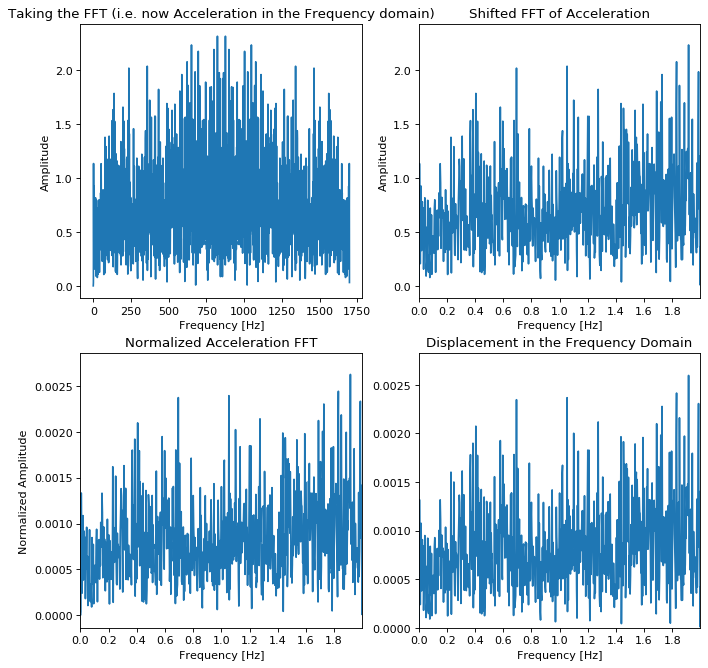

Peak frequency is:  2.422012948793408
Wave height is:  0.005380576066460349


In [11]:
calc_displacement_fft(dacc_array1, f_s=5.0) 
 

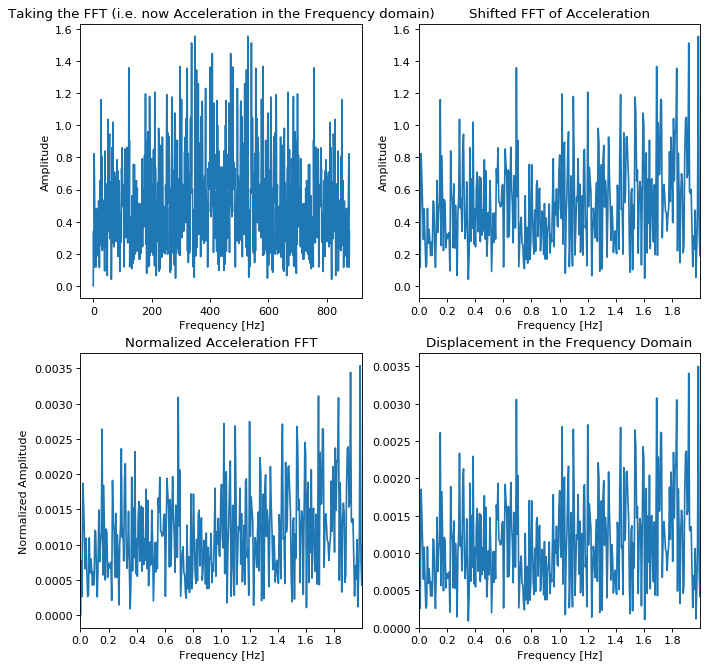

Peak frequency is:  1.9852104664391355
Wave height is:  0.007001797509132898


In [12]:
calc_displacement_fft(dacc_array2, f_s=5.0) 


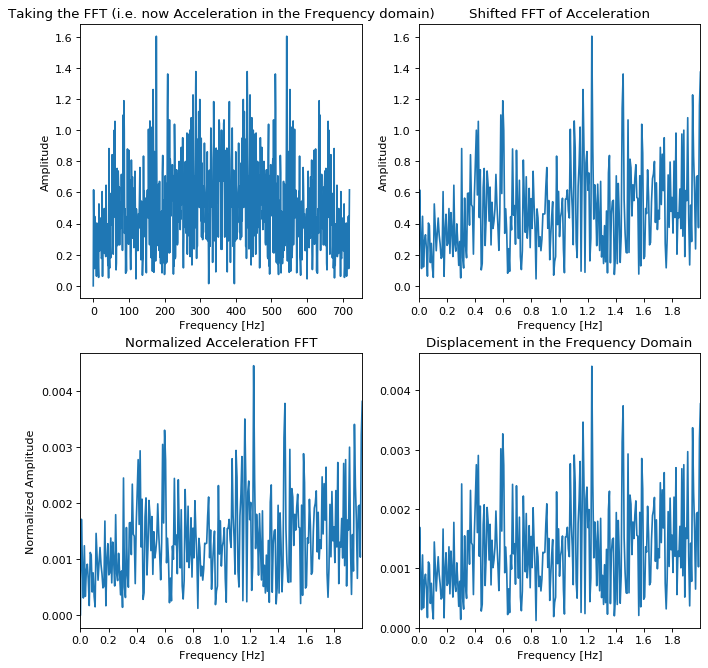

Peak frequency is:  1.2291666666666665
Wave height is:  0.008812453786277345


In [13]:
calc_displacement_fft(dacc_array3, f_s=5.0)